# Baseline Demo for neural signal forecasting

In [1]:
# Build dataloader
import torch
import numpy as np
import os

input_dir = '/home/jovyan/hackdata/neural-forecasting/public_data/'

In [2]:
import torch
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

Torch version: 2.5.1+cu124
CUDA version: 12.4
GPU available: True
GPU name: NVIDIA A10


In [3]:
!nvidia-smi

Sun Jan 18 05:27:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     On  |   00000000:25:00.0 Off |                    0 |
|  0%   31C    P8             22W /  150W |       3MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
# prompt: write a function for torch dataloader

from torch.utils.data import DataLoader, Dataset, TensorDataset


def load_dataset(filename):
    """
    Load test dataset from file.

    Args:
        filename: Name of the test data file

    Returns:
        train_data: Samples to train with shape 
                  (num_samples, num_timestep, num_channels, num_bands)
        test_data: Samples to test with shape 
                  (num_samples, num_timestep, num_channels, num_bands)
        val_data: Samples to validate with shape 
                  (num_samples, num_timestep, num_channels, num_bands)
    """
    test_file = os.path.join(input_dir, filename)
    # Open the file and load the data
    # split into train(80%), test(10%), val(10%)
    data = np.load(test_file)['arr_0']
    train_data = data[:int(len(data)*0.8)]
    test_data = data[int(len(data)*0.8):int(len(data)*0.9)]
    val_data = data[int(len(data)*0.9):]

    return train_data, test_data, val_data


def normalize(data, average=[], std=[]):
    # normalizing input to the range of [~mean - 4*std, ~mean + 4*std]
    # becasue in this dataset, the timestep is in first dimension.
    # adapt the normalization to fit this situation, compute mean and std in axis 0
    if data.ndim == 4:
        n, t, c, f = data.shape
        data = data.reshape((n*t, -1))  # neuron input
    if len(average) == 0:
        average = np.mean(data, axis=0, keepdims=True)
        std = np.std(data, axis=0, keepdims=True)
    combine_max = average + 4 * std
    combine_min = average - 4 * std
    norm_data = 2 * (data - combine_min) / (combine_max - combine_min) - 1
    norm_data = norm_data.reshape((n, t, c, f))
    return norm_data, average, std


class NeuroForcastDataset(Dataset):
  def __init__(self, neural_data, use_graph=False, average=[], std=[]):
    """
    neural_data: N*T*C*F (sampe size * total time steps * channel *feature dimension)
    f_window: T' the length of prediction window
    batch_size: batch size
    """
    self.data = neural_data
    self.use_graph = use_graph
    if len(average) == 0:
      self.data, self.average, self.std = normalize(self.data)
    else:
      self.data, self.average, self.std = normalize(self.data, average, std)

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    if not self.use_graph:
      data = data[:, :, 0]

    data = torch.tensor(data, dtype=torch.float32)
    return data

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.sin(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class NFBaseModel(torch.nn.Module):
  def __init__(self, input_size=96, hidden_size=256, dropout=0.2):
    super(NFBaseModel, self).__init__()
    self.pe = PositionalEncoding()
    self.encoder = torch.nn.TransformerEncoderLayer(
        d_model=input_size, nhead=1, dim_feedforward=hidden_size)
    self.decoder_self_attention = torch.nn.TransformerEncoderLayer(input_size, 1, hidden_size)
    self.decoder_cross_attention = torch.nn.TransformerEncoderLayer(hidden_size, hidden_size)
    self.output_layer = torch.nn.Linear(hidden_size, input_size)

  def forward(self, x):
    output, hidden = self.encoder(x)
    output = self.output_layer(output)
    return output

  def predict(self, x):
    output, hidden = self.encoder(x)
    output = self.output_layer(output)
    return output


class Trainer():
  def __init__(self, model, train_data_loader, test_data_loader,
               val_data_loader, loss_fn, optimizer, device, scheduler,
               forecasting_mode, init_steps=10, save_path='', ckpt_path=None):
    """
    Args:
      model: model to train
      train_data_loader: train data loader
      test_data_loader: test data loader
      val_data_loader: validation data loader
      loss_fn: loss function
      optimizer: optimizer
      device: device
      forecasting_mode: either 'one_step' or 'multi_step'
      init_steps: number of initial steps for multi-step forecasting

    """
    self.model = model
    self.train_data_loader = train_data_loader
    self.test_data_loader = test_data_loader
    self.val_data_loader = val_data_loader

    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device
    self.forecasting_mode = forecasting_mode
    self.init_steps = init_steps

    self.save_path = save_path
    self.ckpt_path = ckpt_path
    if ckpt_path is not None:
      self.load_model(ckpt_path)
    self.model.to(device)
    self.scheduler = scheduler

    self.train_loss = []
    self.test_loss = []
    self.val_loss = []

  def prepare_data(self, data):
    if self.forecasting_mode == 'one_step':
      input_data = data[:, :-1, :]
      target_data = data[:, 1:, :]
    elif self.forecasting_mode == 'multi_step':
      future_step = data.shape[1] - self.init_steps
      # masking out future dataset

      input_data = torch.cat([data[:, :self.init_steps], torch.repeat_interleave(data[:, self.init_steps-1:self.init_steps],
                                                                                 future_step, dim=1)], dim=1)
      target_data = data[:, self.init_steps:]


      # print(f"input_data shape: {input_data.shape}")
      # print(f"target_data shape: {target_data.shape}")
    else:
      raise ValueError(
          'forecasting_mode must be either one_step or multi_step')
    return input_data, target_data

  def loss_function(self, prediction, target):
    if self.forecasting_mode == 'one_step':
      loss = self.loss_fn(prediction, target)
    else:
      loss = self.loss_fn(prediction[:, self.init_steps:], target)
    return loss

  def train(self, num_epochs):
    for epoch in range(num_epochs):
      self.model.train()
      train_loss = 0.0
      for batch in self.train_data_loader:
        batch = batch.to(self.device)
        input_data, target_data = self.prepare_data(batch)
        self.optimizer.zero_grad()
        output = self.model(input_data)
        loss = self.loss_function(output, target_data)
        loss.backward()
        self.optimizer.step()
        train_loss += loss.item()
      if epoch % 10 == 0:
        self.model.eval()
        val_loss = self.validation()
        self.model.train()
        print(f'Epoch {epoch}, Train Loss: {train_loss / len(self.train_data_loader)}, Val Loss:{val_loss / len(self.val_data_loader)}')

  def validation(self):
    self.model.eval()
    val_loss = 0.0
    for batch in self.val_data_loader:
      batch = batch.to(self.device)
      input_data, target_data = self.prepare_data(batch)
      output = self.model(input_data)
      loss = self.loss_fn(output[:, self.init_steps:], target_data)
      val_loss += loss.item()
    return val_loss

  def save_model(self):
    torch.save(self.model.state_dict(), self.save_path)

  def load_model(self, path):
    self.model.load_state_dict(torch.load(self.ckpt_path))

  def prediction(self):
    self.model.eval()
    outputs_pred = []
    outputs_gt = []
    for batch in self.val_data_loader:
      batch = batch.to(self.device)
      input_data, target_data = self.prepare_data(batch)
      output = self.model(input_data)
      outputs_pred.append(output.detach().cpu().numpy())
      outputs_gt.append(target_data.detach().cpu().numpy())
    return outputs_pred, outputs_gt

train_data shape: (788, 20, 239, 9)
test_data shape: (98, 20, 239, 9)
val_data shape: (99, 20, 239, 9)


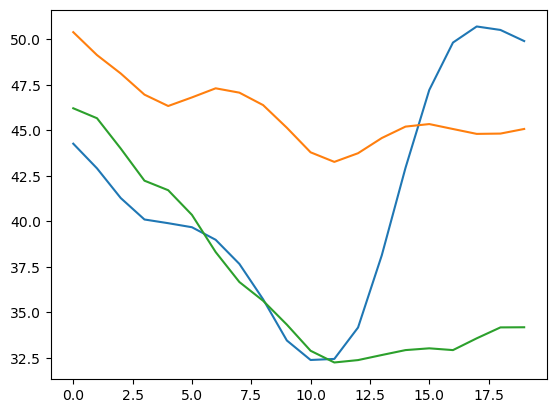

In [18]:
# parameters:
# dataset_name = 'beignet'
dataset_name = 'affi'
if dataset_name == 'beignet':
  num_channels = 89
else:
  num_channels = 239

batch_size = 32
num_epochs = 100
learning_rate = 1e-4
hidden_size = 1024
input_size = num_channels

# define dataloader
train_data, test_data, val_data = load_dataset(
    f'train_data_{dataset_name}.npz')  # B * T * C * F

# print the shape of the train, test, val data
print(f'train_data shape: {train_data.shape}')
print(f'test_data shape: {test_data.shape}')
print(f'val_data shape: {val_data.shape}')

# plot test_data curve for a few channels
import matplotlib.pyplot as plt
plt.plot(test_data[0, :, 0, 1])
plt.plot(test_data[0, :, 1, 1])
plt.plot(test_data[0, :, 2, 1])
plt.show()

In [19]:
# define dataloader

train_ds = NeuroForcastDataset(train_data, use_graph=False)

# Save train_data average and std one file
np.savez(f"train_data_average_std_{dataset_name}.npz",
         average=train_ds.average, std=train_ds.std)

test_ds = NeuroForcastDataset(test_data, use_graph=False,
                              average=train_ds.average, std=train_ds.std)
val_ds  = NeuroForcastDataset(val_data, use_graph=False,
                              average=train_ds.average, std=train_ds.std)

train_data_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_data_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
val_data_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

model = NFBaseModel(hidden_size=hidden_size, input_size=input_size)
model = model.to(torch.device("cuda"))

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lambda1 = lambda ith_epoch: 0.95 ** (ith_epoch // 50)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

trainer = Trainer(
    model, train_data_loader, test_data_loader, val_data_loader,
    loss_fn, optimizer, device=torch.device("cuda"), scheduler=scheduler,
    forecasting_mode="multi_step", init_steps=10, save_path="./model.pth", ckpt_path=None
)

trainer.train(100)

# save the model
torch.save(model.state_dict(), f"model_{dataset_name}.pth")

ValueError: too many values to unpack (expected 2)

In [7]:
# Run one test event and compare the output with the target

# load the model
model_test = NFBaseModel(hidden_size=hidden_size, input_size=input_size)
model_test = model_test.to(torch.device('cuda'))
model_test.load_state_dict(torch.load(f'./model_{dataset_name}.pth'))


def prepare_data(data):
    init_steps = 10
    # forecasting_mode == 'multi_step':
    future_step = data.shape[1] - init_steps
    # masking out future dataset

    input_data = torch.cat([data[:, :init_steps], torch.repeat_interleave(
        data[:, init_steps-1:init_steps], future_step, dim=1)], dim=1)
    target_data = data

    return input_data, target_data


# define r2_score and mse_score
def r2_score(target_data, output):
    return 1 - (torch.sum((target_data - output) ** 2) / torch.sum(target_data ** 2))


def mse_score(target_data, output):
    return torch.mean((target_data - output) ** 2)


# define r2_score and mse_score using numpy
def r2_score_np(target_data, output):
    return 1 - (np.sum((target_data - output) ** 2) / np.sum(target_data ** 2))


def mse_score_np(target_data, output):
    return np.mean((target_data - output) ** 2)

# Run model inference and collect predictions


def run_model_inference(model, data_loader, device):
    """
    Run model inference on test data and collect predictions.
    
    Args:
        model: Trained model
        data_loader: Test data loader
        device: Device to run inference on
    
    Returns:
        predictions: Model predictions as numpy array
        targets: Ground truth targets as numpy array
    """
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch = batch.to(device)

            # Prepare input and target data
            input_data, target_data = prepare_data(batch)
            output = model(input_data)

            # Store predictions and targets
            predictions.append(output.cpu().numpy())
            targets.append(target_data.cpu().numpy())

    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    return predictions, targets


# Run inference
predictions, targets = run_model_inference(
    model_test, test_data_loader, torch.device('cuda'))

# Calculate evaluation metrics
r2 = r2_score(torch.tensor(targets), torch.tensor(predictions))
mse = mse_score(torch.tensor(targets), torch.tensor(predictions))

# Calculate evaluation metrics using numpy
r2_np = r2_score_np(np.array(targets), np.array(predictions))
mse_np = mse_score_np(np.array(targets), np.array(predictions))

print(f'Test R2 score: {r2:.4f}')
print(f'Test MSE score: {mse:.4f}')
print(f'Test R2 score(NP): {r2_np:.4f}')
print(f'Test MSE score(NP): {mse_np:.4f}')

NameError: name 'NFBaseModel' is not defined

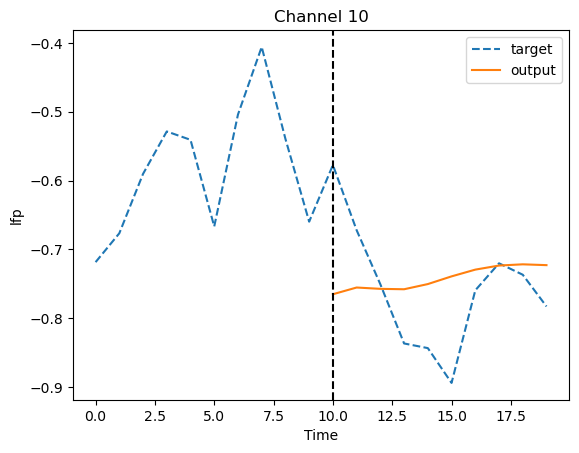

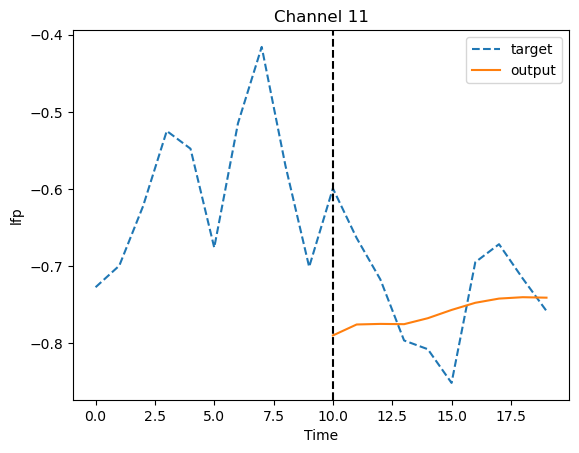

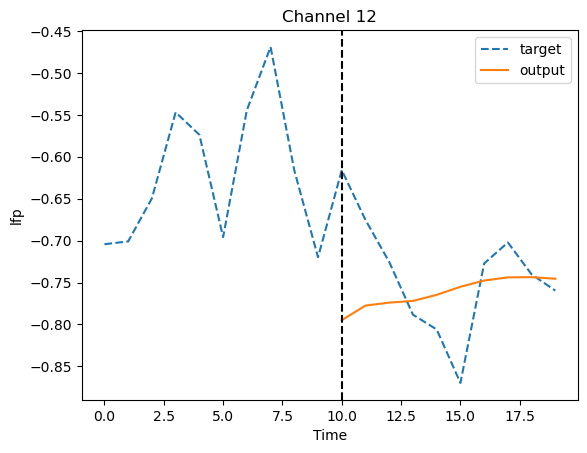

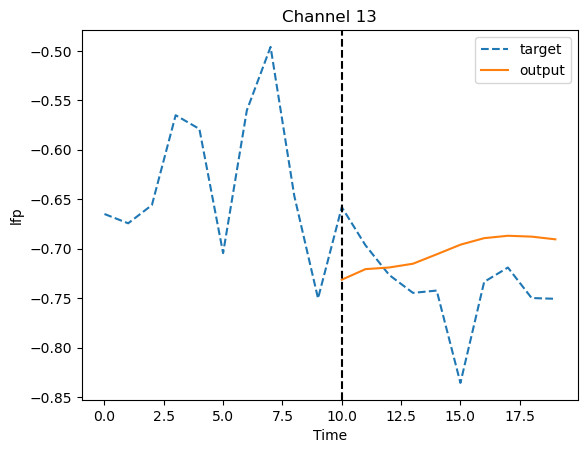

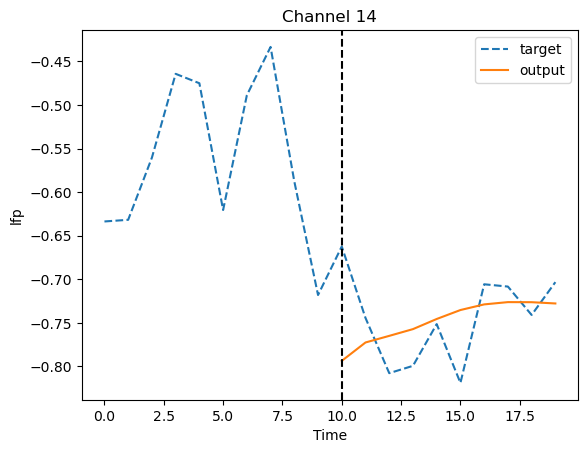

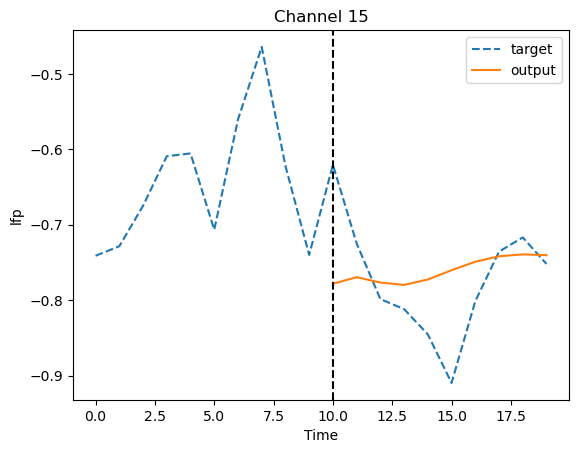

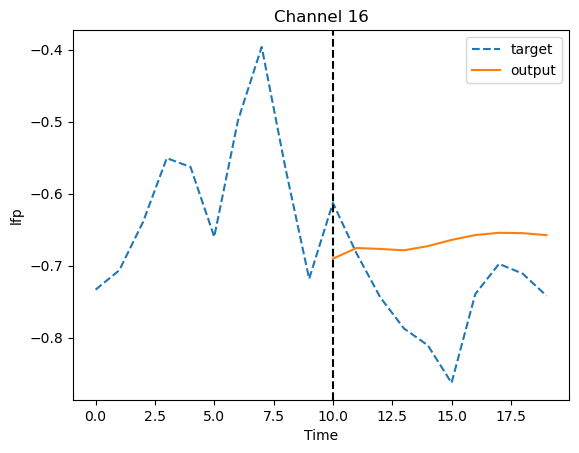

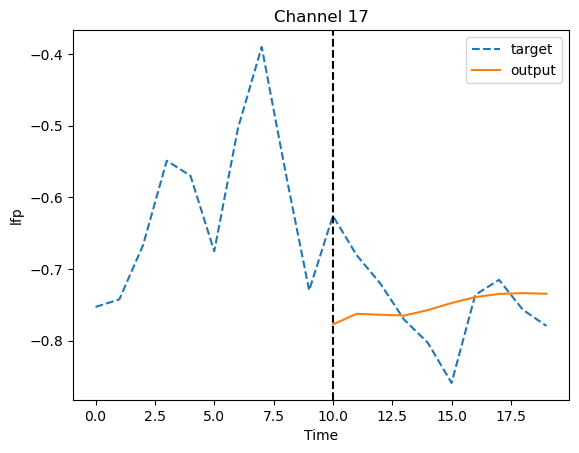

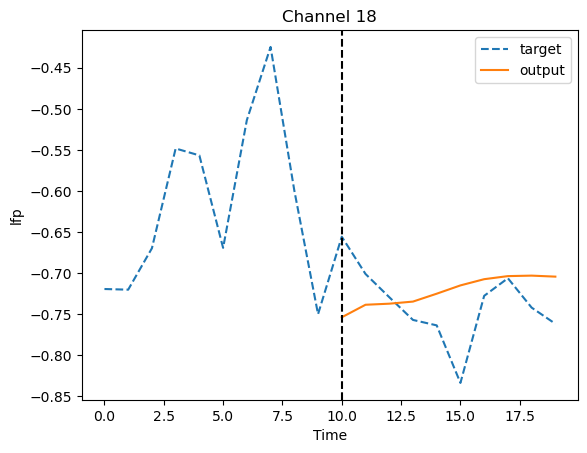

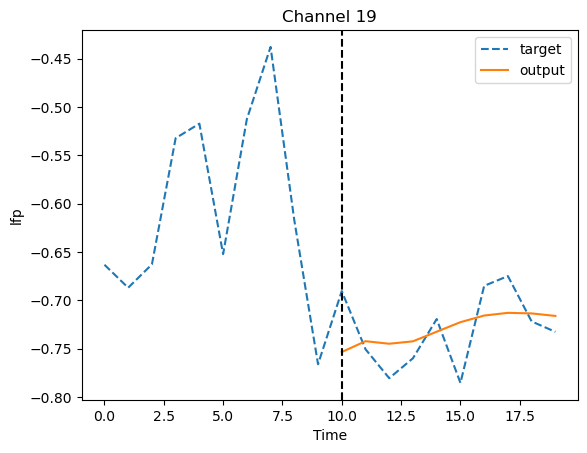

In [21]:
# Compare the output and target data for channels

output_data_list = predictions
target_data_list = targets
init_steps = 10

def plot_channel(channel_idx):
    # target (full sequence)
    plt.plot(target_data_list[0, :, channel_idx], "--", label="target")

    # model output starting from init_steps
    x_output = np.arange(init_steps, target_data_list.shape[1])
    plt.plot(x_output, output_data_list[0, init_steps:, channel_idx], "-", label="output")

    # vertical line at init_steps
    plt.axvline(x=init_steps, color="black", linestyle="--")
    plt.legend()
    plt.title(f"Channel {channel_idx}")
    plt.xlabel("Time")
    plt.ylabel("lfp")
    plt.show()

for ch in range(10, 20):
    plot_channel(ch)

In [8]:
len(train_data_loader)

25

In [27]:
train_data_loader

In [10]:
len(train_data)

788

In [16]:
train_data[0].shape

(20, 239, 9)

In [19]:
train_data[0][0][0][1:].sum()

np.float64(310.31474310888285)

In [30]:
len(train_data_loader)

25

In [45]:
for batch in train_data_loader:
    print(torch.repeat_interleave(batch[:, 10-1:10], 10, dim=1).shape)
    print(batch[:, 10-1:10].shape)
    break

torch.Size([32, 10, 239])
torch.Size([32, 1, 239])
